In [1]:
from tqdm import tqdm
import pandas as pd
from tabulate import tabulate
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as patches

d:\PrivateProjects\WroclawWeatherPredictor\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
SEQ_LENGTH = 24
DATA_FILE = './data/meteo_16.9_51.103333_2025-11-30_2015-12-31.csv'

FEATURES = ['temperature_2m','relative_humidity_2m','apparent_temperature','surface_pressure','wind_direction_10m','wind_speed_10m','soil_temperature_0_to_7cm','soil_moisture_0_to_7cm','rain','dew_point_2m','snowfall','snow_depth','cloud_cover']
TARGET = 'temperature_2m'

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# PREPARE DATE

In [4]:
df = pd.read_csv(DATA_FILE)

In [5]:
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------+
|    | date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0_to_7cm |   soil_moisture_0_to_7cm |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------|
|  0 | 2015-12-31 23:00:00+00:00 |          -4.5345 |                71.9106 |               -8.90121 |            101

In [6]:
nan_counts = df.isna().sum()
print("NaN counts per column:")
print(tabulate(nan_counts.reset_index().rename(columns={'index': 'Column', 0: 'NaN Count'}), headers='keys', tablefmt='psql'))

NaN counts per column:
+----+---------------------------+-------------+
|    | Column                    |   NaN Count |
|----+---------------------------+-------------|
|  0 | date                      |           0 |
|  1 | temperature_2m            |           0 |
|  2 | relative_humidity_2m      |           0 |
|  3 | apparent_temperature      |           0 |
|  4 | surface_pressure          |           0 |
|  5 | wind_direction_10m        |           0 |
|  6 | wind_speed_10m            |           0 |
|  7 | soil_temperature_0_to_7cm |           0 |
|  8 | soil_moisture_0_to_7cm    |           0 |
|  9 | rain                      |           0 |
| 10 | dew_point_2m              |           0 |
| 11 | snowfall                  |           0 |
| 12 | snow_depth                |           0 |
| 13 | cloud_cover               |           0 |
+----+---------------------------+-------------+


In [7]:
unique_cols = list(pd.unique(FEATURES + [TARGET, 'date']))
df = df[unique_cols]

df.reset_index(drop=True, inplace=True)
print("Dataframe shape after filtering:", df.shape)

Dataframe shape after filtering: (86928, 14)


C:\Users\dzied\AppData\Local\Temp\ipykernel_23400\985636812.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  unique_cols = list(pd.unique(FEATURES + [TARGET, 'date']))


In [8]:
df['date'] = pd.to_datetime(df['date'])
df['Date'] = df['date'].dt.floor('D')
df_daily = df.groupby('Date').mean(numeric_only=True)
df_daily['Timespan'] = df_daily.index.to_series().diff()
df_daily.reset_index(inplace=True)

In [9]:
print("Dataframe shape after dropping NaNs:", df_daily.shape)
print(tabulate(df_daily.head(), headers='keys', tablefmt='psql'))

Dataframe shape after dropping NaNs: (3623, 15)
+----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------+-----------------+
|    | Date                      |   temperature_2m |   relative_humidity_2m |   apparent_temperature |   surface_pressure |   wind_direction_10m |   wind_speed_10m |   soil_temperature_0_to_7cm |   soil_moisture_0_to_7cm |   rain |   dew_point_2m |   snowfall |   snow_depth |   cloud_cover | Timespan        |
|----+---------------------------+------------------+------------------------+------------------------+--------------------+----------------------+------------------+-----------------------------+--------------------------+--------+----------------+------------+--------------+---------------+-----------------|
|  0 | 2015-12-3

In [10]:
INPUT_WIDTH = 168
LABEL_WIDTH = 168
SHIFT = 168
FEATURES_COL = FEATURES + ['Day sin', 'Day cos']
TARGET_COL = TARGET


df['date'] = pd.to_datetime(df['date'])
df_hourly = df.set_index('date')[FEATURES].resample('h').mean()
df_hourly = df_hourly.interpolate(method='linear')

timestamp_s = df_hourly.index.map(pd.Timestamp.timestamp)
day = 24*60*60
df_hourly['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df_hourly['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))


df_summer = df_hourly[df_hourly.index.month.isin([4, 5, 6, 7, 8, 9])].copy()

df_winter = df_hourly[df_hourly.index.month.isin([10, 11, 12, 1, 2, 3])].copy()

df_summer.dropna(inplace=True)
df_winter.dropna(inplace=True)

print(f"Dane Letnie: {df_summer.shape}")
print(f"Dane Zimowe: {df_winter.shape}")


def prepare_seasonal_data(df_season):
    n = len(df_season)
    train = df_season[0:int(n*0.7)]
    val = df_season[int(n*0.7):int(n*0.9)]
    test = df_season[int(n*0.9):]
    scaler = MinMaxScaler()
    scaler.fit(train)

    return scaler, scaler.transform(train), scaler.transform(val), scaler.transform(test)


scaler_S, train_S, val_S, test_S = prepare_seasonal_data(df_summer)
scaler_W, train_W, val_W, test_W = prepare_seasonal_data(df_winter)




Dane Letnie: (43920, 15)
Dane Zimowe: (43008, 15)


In [11]:
def create_multistep_dataset(dataset, input_width, label_width, target_col_idx):
    X, y = [], []
    for i in range(len(dataset) - input_width - label_width + 1):
        X.append(dataset[i : i + input_width, :])
        y.append(dataset[i + input_width : i + input_width + label_width, target_col_idx])
    return np.array(X), np.array(y)

target_idx = df_hourly.columns.get_loc(TARGET_COL)

print("Generowanie sekwencji LATO...")
X_train_S, y_train_S = create_multistep_dataset(train_S, INPUT_WIDTH, LABEL_WIDTH, target_idx)
X_val_S, y_val_S = create_multistep_dataset(val_S, INPUT_WIDTH, LABEL_WIDTH, target_idx)
X_test_S, y_test_S = create_multistep_dataset(test_S, INPUT_WIDTH, LABEL_WIDTH, target_idx)

print("Generowanie sekwencji ZIMA...")
X_train_W, y_train_W = create_multistep_dataset(train_W, INPUT_WIDTH, LABEL_WIDTH, target_idx)
X_val_W, y_val_W = create_multistep_dataset(val_W, INPUT_WIDTH, LABEL_WIDTH, target_idx)
X_test_W, y_test_W = create_multistep_dataset(test_W, INPUT_WIDTH, LABEL_WIDTH, target_idx)

Generowanie sekwencji LATO...
Generowanie sekwencji ZIMA...



☀️ ROZPOCZYNAM TRENING MODELU LETNIEGO ☀️
Epoch 1/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 42s 39ms/step - loss: 0.0662 - mean_absolute_error: 0.1937 - val_loss: 0.0145 - val_mean_absolute_error: 0.0961 - learning_rate: 1.0000e-04
Epoch 2/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 35s 37ms/step - loss: 0.0229 - mean_absolute_error: 0.1200 - val_loss: 0.0135 - val_mean_absolute_error: 0.0938 - learning_rate: 1.0000e-04
Epoch 3/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - loss: 0.0190 - mean_absolute_error: 0.1099 - val_loss: 0.0131 - val_mean_absolute_error: 0.0922 - learning_rate: 1.0000e-04
Epoch 4/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0173 - mean_absolute_error: 0.1049 - val_loss: 0.0129 - val_mean_absolute_error: 0.0918 - learning_rate: 1.0000e-04
Epoch 5/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - loss: 0.0161 - mean_absolute_error: 0.1014 - val_loss: 0.0128 - val_mean_absolute_error: 0.0910 - learning_rate: 1.0000e-04
Epoch 6/40
951/951 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - l

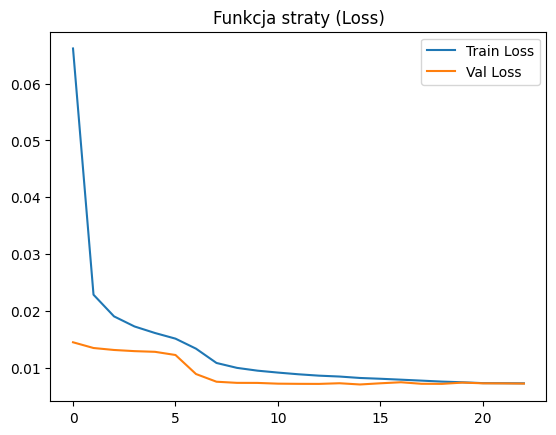

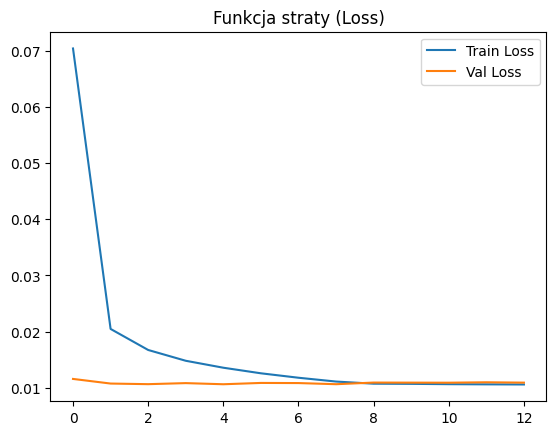

In [12]:
def build_model(name="Model"):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(INPUT_WIDTH, len(FEATURES_COL))),

        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.LSTM(32, return_sequences=False),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(LABEL_WIDTH)
    ], name=name)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

model_summer = build_model("Summer_Model")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min', restore_best_weights=True)
reduce_rl = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

print("\n☀️ ROZPOCZYNAM TRENING MODELU LETNIEGO ☀️")
history_S = model_summer.fit(
    X_train_S, y_train_S,
    epochs=40, batch_size=32,
    validation_data=(X_val_S, y_val_S),
    callbacks=[early_stopping, reduce_rl], verbose=1
)

model_winter = build_model("Winter_Model")
early_stopping_W = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min', restore_best_weights=True)
reduce_rl_W = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)


print("\n❄️ ROZPOCZYNAM TRENING MODELU ZIMOWEGO ❄️")
history_W = model_winter.fit(
    X_train_W, y_train_W,
    epochs=40, batch_size=32,
    validation_data=(X_val_W, y_val_W),
    callbacks=[early_stopping_W, reduce_rl_W], verbose=1
)

plt.plot(history_S.history['loss'], label='Train Loss')
plt.plot(history_S.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Funkcja straty (Loss)")
plt.show()

plt.plot(history_W.history['loss'], label='Train Loss')
plt.plot(history_W.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Funkcja straty (Loss)")
plt.show()


WYNIKI TESTU KRZYŻOWEGO (CROSS-EVALUATION)
[Model Letni] na danych [LATO]:
   -> Scaled MAE: 0.0752
   -> Real MAE (ok.): 3.03°C
[Model Zimowy] na danych [ZIMA]:
   -> Scaled MAE: 0.0804
   -> Real MAE (ok.): 3.41°C
----------------------------------------
[Model Letni] na danych [ZIMA]:
   -> Scaled MAE: 0.0974
   -> Real MAE (ok.): 3.92°C
[Model Zimowy] na danych [LATO]:
   -> Scaled MAE: 0.1125
   -> Real MAE (ok.): 4.78°C


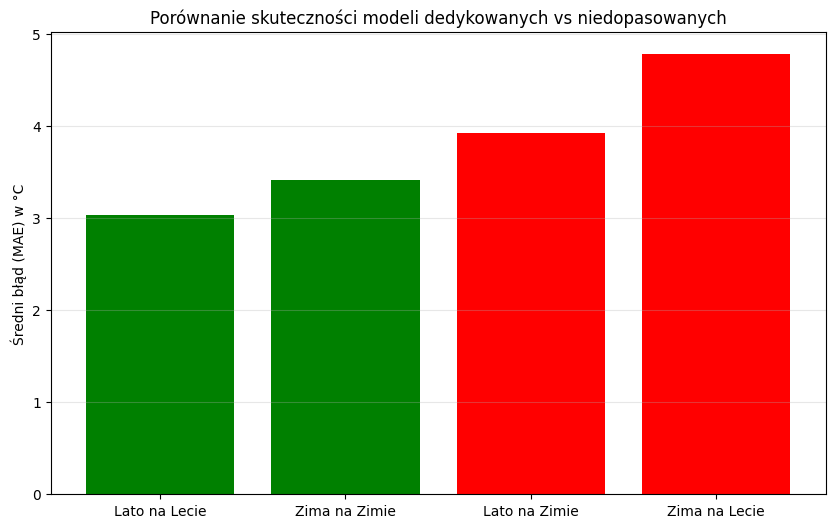

In [13]:
def evaluate_cross_performance(model, raw_df_test, scaler_model, model_name, data_name):

    test_scaled = scaler_model.transform(raw_df_test)

    target_idx = df_hourly.columns.get_loc(TARGET_COL)
    X_test, y_test = create_multistep_dataset(test_scaled, INPUT_WIDTH, LABEL_WIDTH, target_idx)

    loss, mae = model.evaluate(X_test, y_test, verbose=0)


    temp_range = scaler_model.data_max_[0] - scaler_model.data_min_[0]
    real_mae = mae * temp_range

    print(f"[{model_name}] na danych [{data_name}]:")
    print(f"   -> Scaled MAE: {mae:.4f}")
    print(f"   -> Real MAE (ok.): {real_mae:.2f}°C")
    return real_mae

print("\n" + "="*40)
print("WYNIKI TESTU KRZYŻOWEGO (CROSS-EVALUATION)")
print("="*40)

_, _, _, df_test_S_raw = prepare_seasonal_data(df_summer)
_, _, _, df_test_W_raw = prepare_seasonal_data(df_winter)


n_s = len(df_summer)
test_S_raw = df_summer[int(n_s*0.9):]

n_w = len(df_winter)
test_W_raw = df_winter[int(n_w*0.9):]

mae_SS = evaluate_cross_performance(model_summer, test_S_raw, scaler_S, "Model Letni", "LATO")

mae_WW = evaluate_cross_performance(model_winter, test_W_raw, scaler_W, "Model Zimowy", "ZIMA")

print("-" * 40)

mae_SW = evaluate_cross_performance(model_summer, test_W_raw, scaler_S, "Model Letni", "ZIMA")

mae_WS = evaluate_cross_performance(model_winter, test_S_raw, scaler_W, "Model Zimowy", "LATO")

plt.figure(figsize=(10, 6))
bar_colors = ['green', 'green', 'red', 'red']
maes = [mae_SS, mae_WW, mae_SW, mae_WS]
labels = ['Lato na Lecie', 'Zima na Zimie', 'Lato na Zimie', 'Zima na Lecie']

plt.bar(labels, maes, color=bar_colors)
plt.ylabel('Średni błąd (MAE) w °C')
plt.title('Porównanie skuteczności modeli dedykowanych vs niedopasowanych')
plt.grid(axis='y', alpha=0.3)
plt.show()

Obliczanie błędów dla: MODEL LETNI (Kwiecień-Wrzesień)...


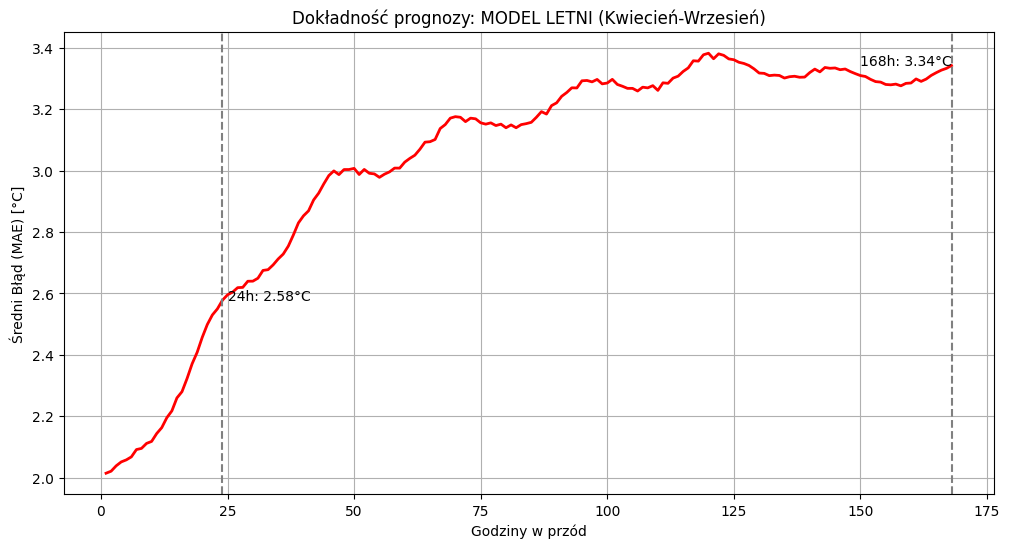

Obliczanie błędów dla: MODEL ZIMOWY (Październik-Marzec)...


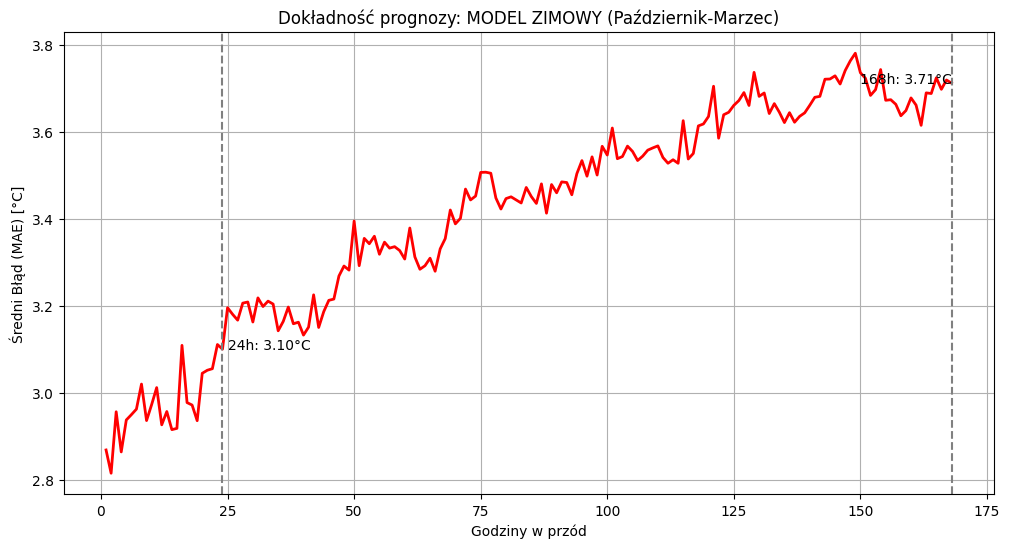

In [14]:
def plot_error_by_hour(model, X_test, y_test, scaler, title_suffix=""):
    print(f"Obliczanie błędów dla: {title_suffix}...")
    predictions = model.predict(X_test, verbose=0)

    # Automatyczne wykrycie liczby cech ze scalera (bezpieczniejsze niż globalne FEATURES)
    n_features = scaler.n_features_in_

    # Denormalizacja
    pred_expanded = np.zeros((predictions.shape[0], predictions.shape[1], n_features))
    pred_expanded[:, :, 0] = predictions

    true_expanded = np.zeros((y_test.shape[0], y_test.shape[1], n_features))
    true_expanded[:, :, 0] = y_test

    N, T, F = pred_expanded.shape

    pred_flat = pred_expanded.reshape(N*T, F)
    true_flat = true_expanded.reshape(N*T, F)

    pred_unscaled = scaler.inverse_transform(pred_flat)[:, 0].reshape(N, T)
    true_unscaled = scaler.inverse_transform(true_flat)[:, 0].reshape(N, T)

    mae_per_hour = np.mean(np.abs(pred_unscaled - true_unscaled), axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 169), mae_per_hour, color='red', linewidth=2)
    plt.title(f'Dokładność prognozy: {title_suffix}')
    plt.xlabel('Godziny w przód')
    plt.ylabel('Średni Błąd (MAE) [°C]')
    plt.grid(True)

    # Punkty kontrolne
    if len(mae_per_hour) >= 24:
        plt.axvline(x=24, color='gray', linestyle='--')
        plt.text(25, mae_per_hour[23], f'24h: {mae_per_hour[23]:.2f}°C')

    if len(mae_per_hour) >= 168:
        plt.axvline(x=168, color='gray', linestyle='--')
        plt.text(150, mae_per_hour[167], f'168h: {mae_per_hour[167]:.2f}°C')

    plt.show()

# --- URUCHOMIENIE DLA OBU MODELI ---
plot_error_by_hour(model_summer, X_test_S, y_test_S, scaler_S, title_suffix="MODEL LETNI (Kwiecień-Wrzesień)")
plot_error_by_hour(model_winter, X_test_W, y_test_W, scaler_W, title_suffix="MODEL ZIMOWY (Październik-Marzec)")

--- PRZYKŁAD: LATO (72h) ---


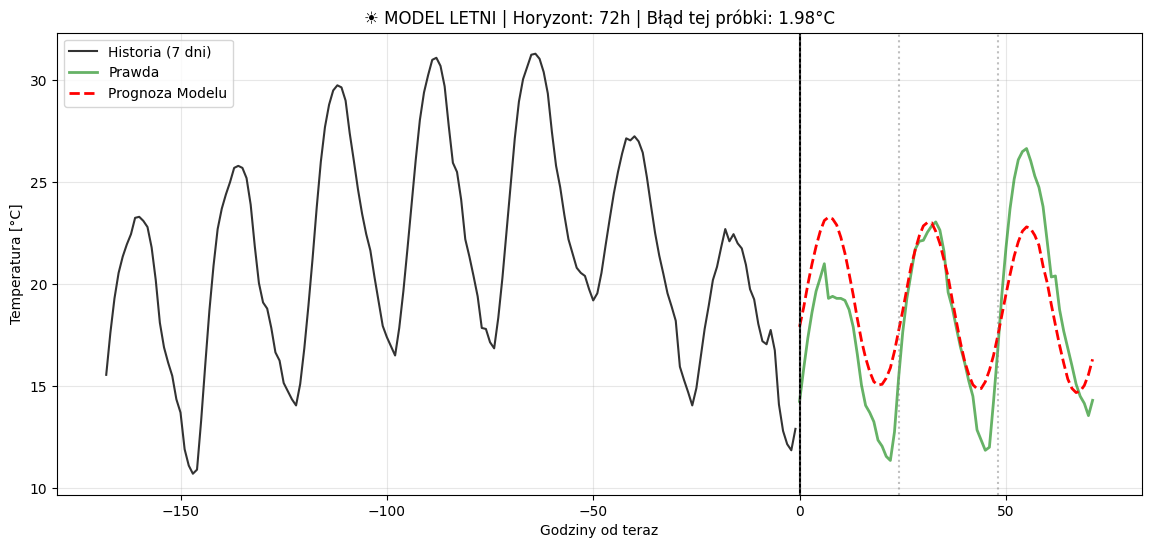


--- PRZYKŁAD: ZIMA (3 dni / 72h) ---


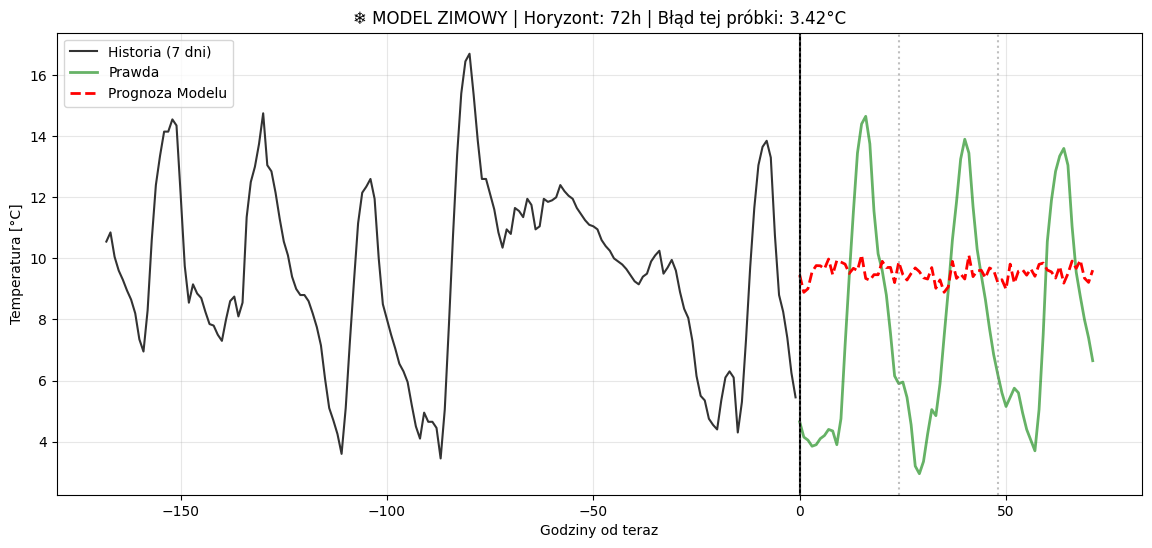

In [15]:
def interactive_forecast(model, X_test, y_test, scaler, hours_to_predict=168, title="Prognoza"):
    """
    model, X_test, y_test, scaler: konkretny zestaw (np. letni lub zimowy)
    hours_to_predict: int, od 1 do 168
    """
    if hours_to_predict > 168:
        hours_to_predict = 168

    # Losujemy próbkę z przekazanego zbioru testowego
    idx = np.random.randint(0, len(X_test))

    input_seq = X_test[idx]
    true_future = y_test[idx]

    # Predykcja
    full_prediction = model.predict(input_seq[np.newaxis, ...], verbose=0)[0]

    # Denormalizacja (używamy n_features_in_ ze scalera)
    n_features = scaler.n_features_in_

    dummy_pred = np.zeros((len(full_prediction), n_features))
    dummy_pred[:, 0] = full_prediction
    pred_unscaled = scaler.inverse_transform(dummy_pred)[:, 0]

    dummy_true = np.zeros((len(true_future), n_features))
    dummy_true[:, 0] = true_future
    true_unscaled = scaler.inverse_transform(dummy_true)[:, 0]

    history_unscaled = scaler.inverse_transform(input_seq)[:, 0]

    # Cięcie do wybranego horyzontu
    pred_cut = pred_unscaled[:hours_to_predict]
    true_cut = true_unscaled[:hours_to_predict]

    local_mae = np.mean(np.abs(pred_cut - true_cut))

    # Wykres
    plt.figure(figsize=(14, 6))

    # Historia
    hist_range = np.arange(-len(history_unscaled), 0)
    plt.plot(hist_range, history_unscaled, color='#333333', label='Historia (7 dni)')

    # Przyszłość
    future_range = np.arange(0, hours_to_predict)
    plt.plot(future_range, true_cut, color='green', label='Prawda', alpha=0.6, linewidth=2)
    plt.plot(future_range, pred_cut, color='red', linestyle='--', label='Prognoza Modelu', linewidth=2)

    plt.title(f'{title} | Horyzont: {hours_to_predict}h | Błąd tej próbki: {local_mae:.2f}°C')
    plt.xlabel('Godziny od teraz')
    plt.ylabel('Temperatura [°C]')
    plt.axvline(x=0, color='black')

    # Oznaczenie dni pionowymi liniami
    for i in range(0, hours_to_predict, 24):
        plt.axvline(x=i, color='gray', linestyle=':', alpha=0.5)

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- PRZYKŁADOWE WYWOŁANIA ---

print("--- PRZYKŁAD: LATO (72h) ---")
interactive_forecast(model_summer, X_test_S, y_test_S, scaler_S, hours_to_predict=72, title="☀️ MODEL LETNI")

print("\n--- PRZYKŁAD: ZIMA (3 dni / 72h) ---")
interactive_forecast(model_winter, X_test_W, y_test_W, scaler_W, hours_to_predict=72, title="❄️ MODEL ZIMOWY")

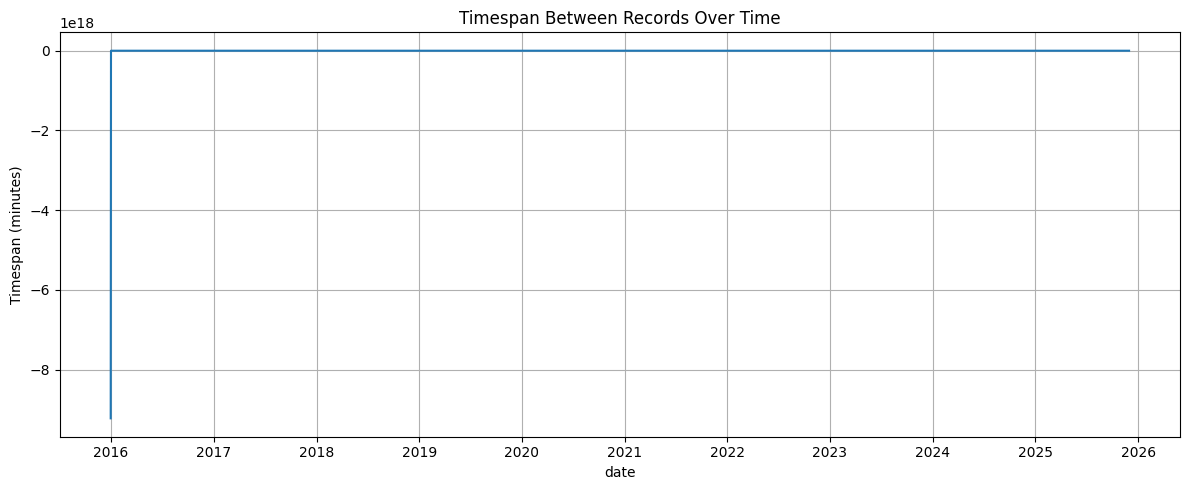

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(df_daily['Date'], df_daily['Timespan'])
plt.title('Timespan Between Records Over Time')
plt.xlabel('date')
plt.ylabel('Timespan (minutes)')
plt.grid(True)
plt.tight_layout()
plt.show()
